In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [71]:
train = pd.read_csv('./data/train.csv')
train.head()

,Id,Target,Duration,Language,Country,Rating,Action,Adventure,Animation,Biography,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,Poster
0,1,0,139,English,France,PG-13,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1.jpg
1,2,0,90,English,USA,R,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.jpg
2,3,0,103,Mandarin,China,R,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.jpg
3,4,0,108,Dzongkha,Australia,NaN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.jpg
4,5,0,122,English,USA,PG-13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5.jpg


In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 28 columns):
Id             3635 non-null int64
Target         3635 non-null int64
Duration       3635 non-null int64
Language       3629 non-null object
Country        3635 non-null object
Rating         3522 non-null object
Action         3635 non-null int64
Adventure      3635 non-null int64
Animation      3635 non-null int64
Biography      3635 non-null int64
Crime          3635 non-null int64
Documentary    3635 non-null int64
Drama          3635 non-null int64
Family         3635 non-null int64
Fantasy        3635 non-null int64
History        3635 non-null int64
Horror         3635 non-null int64
Music          3635 non-null int64
Musical        3635 non-null int64
Mystery        3635 non-null int64
News           3635 non-null int64
Romance        3635 non-null int64
Sci-Fi         3635 non-null int64
Sport          3635 non-null int64
Thriller       3635 non-null int64
War            

Преобразуем категориальный признак `Language`

In [73]:
train['Language'].describe()

count        3629
unique         41
top       English
freq         3395
Name: Language, dtype: object

In [74]:
train['Language'] = train['Language'].fillna('None')

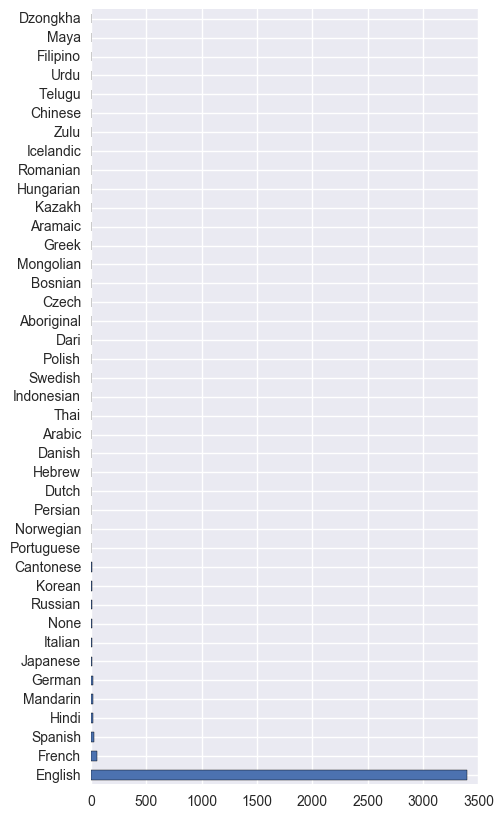

In [75]:
plt.figure(figsize=(5,10))
train['Language'].value_counts().plot.barh()

In [88]:
lang_encoder = LabelBinarizer()
lang_values = lang_encoder.fit_transform(train['Language'])
train = pd.concat([train.drop(['Language'], axis=1), pd.DataFrame(columns=lang_encoder.classes_, data=lang_values)], axis=1)

In [89]:
train.head()

,Id,Target,Duration,Country,Rating,Action,Adventure,Animation,Biography,Crime,...,Polish,Portuguese,Romanian,Russian,Spanish,Swedish,Telugu,Thai,Urdu,Zulu
0,1,0,139,France,PG-13,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,90,USA,R,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,103,China,R,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,108,Australia,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,122,USA,PG-13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Преобразуем категориальный признак `Country`

In [90]:
train['Country'] = train['Country'].fillna('None')

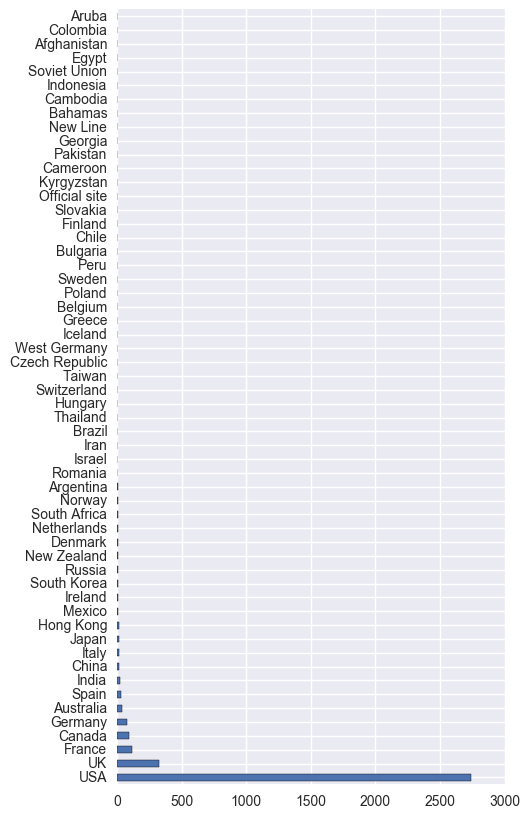

In [91]:
plt.figure(figsize=(5,10))
train['Country'].value_counts().plot.barh()

In [92]:
country_encoder = LabelBinarizer()
country_values = country_encoder.fit_transform(train['Country'])
train = pd.concat([train.drop(['Country'], axis=1), pd.DataFrame(columns=country_encoder.classes_, data=country_values)], axis=1)

In [93]:
train.head()

,Id,Target,Duration,Rating,Action,Adventure,Animation,Biography,Crime,Documentary,...,South Korea,Soviet Union,Spain,Sweden,Switzerland,Taiwan,Thailand,UK,USA,West Germany
0,1,0,139,PG-13,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,90,R,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,103,R,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,108,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,122,PG-13,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 123 entries, Id to West Germany
dtypes: int32(97), int64(24), object(2)
memory usage: 2.0+ MB


Рассмотрим оставшиеся нечисловые данные

In [96]:
train.select_dtypes(include=['object']).columns

Index(['Rating', 'Poster'], dtype='object')

Обработаем `Rating`

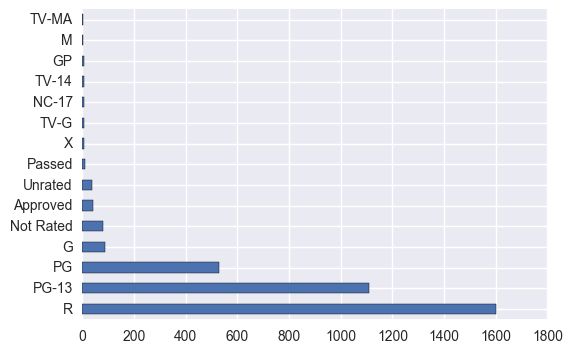

In [97]:
train['Rating'].value_counts().plot.barh()

Обобщим данные согласно этим данным https://en.wikipedia.org/wiki/Motion_picture_content_rating_system

In [99]:
def transform_rating(rating):
    if rating in ['GP', 'Unrated', 'Passed', 'Not Rated', 'Approved', 'G']:
        return 'White'
    elif rating in ['TV-G', 'PG']:
        return 'Yellow'
    elif rating in ['M', 'TV-14', 'PG-13']:
        return 'Purple'
    elif rating in ['R']:
        return 'Red'
    elif rating in ['TV-MA', 'NG-17', 'X']:
        return 'Black'
    else:
        return 'None'

In [100]:
train['Rating'] = train['Rating'].apply(transform_rating)

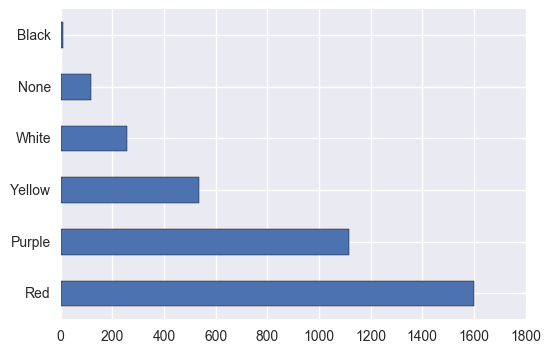

In [101]:
train['Rating'].value_counts().plot.barh()

In [102]:
rating_encoder = LabelBinarizer()
rating_values = rating_encoder.fit_transform(train['Rating'])
train = pd.concat([train.drop(['Rating'], axis=1), pd.DataFrame(columns=rating_encoder.classes_, data=rating_values)], axis=1)

In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 128 entries, Id to Yellow
dtypes: int32(103), int64(24), object(1)
memory usage: 2.1+ MB


Построение модели без учета картинок

In [114]:
test = train['Target']

KeyError: 'Target'

In [110]:
train = train.drop(['Poster', 'Target'], axis=1)

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 126 entries, Id to Yellow
dtypes: int32(103), int64(23)
memory usage: 2.1 MB


In [123]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)
print(y_train.shape)
print(y_test.shape)

(2908,)
(727,)


In [134]:
est = LogisticRegression()
est.fit(X_train, y_train)
roc_auc_score(y_test, est.predict_proba(X_test)[:,1])

0.88650473630312343

In [142]:
est = RandomForestClassifier(n_estimators=20)
est.fit(X_train, y_train)
roc_auc_score(y_test, est.predict_proba(X_test)[:,1])

0.85503072196620589